# Загружаем Необходимые Библиотеки

In [13]:
import numpy as np
import random
import os
import cv2
import pandas as pd
import mediapipe as mp

from zz.Face_model import TL_Faces_00
from utils.utils import *
from utils.loader import DatasetForTLFacesFromCSV

# Загружаем Модель с весами. Модель - Класстеризатор 

In [14]:
"""
Модель переводит вектор 225 в вектор размера 128
Используются 4 линейных слоя с функциями активации LeakyReLU.
Также присутствуют Dropout
Функция потерь: torch.nn.TripletMarginLoss
Оптимизатор: adam
Для Предобучения модели также использовался классификатор из 300 папок
"""
IMAGE_SIZE = [225] 
device = 'cpu'
TL_001 = TL_Faces_00(imageSize = IMAGE_SIZE, device=device, margin_=5, show=0)
TL_001.compile(criterion='mse-mean', optimizer='adam', lr=0.0001, momentum=0.8)
TL_001.fully_connect_modul_TL1.load_state('weights/new_225_07.pt', map_location = device)
TL_001.summary() 
#TL_001.eval()


Loading preset weights... Ok.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]          45,200
           Dropout-2                  [-1, 200]               0
         LeakyReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 170]          34,170
           Dropout-5                  [-1, 170]               0
         LeakyReLU-6                  [-1, 170]               0
            Linear-7                  [-1, 140]          23,940
         LeakyReLU-8                  [-1, 140]               0
            Linear-9                  [-1, 128]          18,048
fully_connect_modul_300-10                  [-1, 128]               0
      TL_Faces_00-11                  [-1, 128]               0
Total params: 121,358
Trainable params: 121,358
Non-trainable params: 0
----------------------------------------------------------

# Библиотека MediaPipe. Пример работы. Получение Landmarks

In [15]:
def convert_landmark(path):
    """
    Параметры на вход:
    path - Путь до файла(фотографии)
    Схема работы Скрипта:
    1)Загружается модуль mp_face_mesh.FaceMesh:
    -static_image_mode - Статичное изображение или видео
    -max_num_faces - Максимальная количество лиц для детекции
    -refine_landmarks - Уточнение
    2) mp_indices - Выбираем какие точки нужны для алгоритма
    -[0, 39, 269, 181, 405, 61, 291, 43, 273, 62, 292ъ - точки рта
    -[4, 152, 70, 46, 105, 52, 107, 55, 285, 336, 334, 282, 300, 276, 344, 429, 220, 115] - точки носа 
    -[33, 133, 159, 145, 362, 263, 385, 374] - точки глаз
    -[148, 176, 149, 150, 136, 172, 58, 215, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109, 10, 
    338, 297, 332, 284, 251, 389, 356, 264, 447, 366, 401, 435, 288, 397, 365, 379, 378, 400,
    377, 152, 70, 46] - точки окреность лица
    3) Центрируем и нормируем каждую координату точки. На выходе получаем вектор [1,225]
    """
    result = []

    mp_face_mesh = mp.solutions.face_mesh

    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=30, refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        image = cv2.imread(path)
        output = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if output.multi_face_landmarks:
            for i_face, face in enumerate(output.multi_face_landmarks):
                x = []
                y = []
                z = []

                mp_indices = sorted([0, 4, 39, 269, 181, 405, 61, 291, 43, 273, 62, 292, 33, 133,
                                     159, 145, 362, 263, 385, 374,148, 176, 149, 150, 136, 172, 58,
                                     215, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109, 10, 338, 297,
                                     332, 284, 251, 389, 356, 264, 447, 366, 401, 435, 288, 397, 365,
                                     379, 378, 400,377, 152, 70, 46, 105, 52, 107, 55, 285, 336, 334,
                                     282, 300, 276, 344, 429, 220, 115])

                for idx in mp_indices:
                    x.append(output.multi_face_landmarks[i_face].landmark[idx].x)
                    y.append(output.multi_face_landmarks[i_face].landmark[idx].y)
                    z.append(output.multi_face_landmarks[i_face].landmark[idx].z)

                array = np.array([x, y, z]).T
                center_0 = np.mean(array,0)
                centered_lndmrk = array - center_0
                f_0 = np.linalg.norm(centered_lndmrk, axis = -1)
                f_1 = centered_lndmrk / np.linalg.norm(f_0)
                f_2 = f_1.reshape(f_1.shape[0] * f_1.shape[1],)
                result.append(f_2)

        return np.array(result)

# Пример работы  функции convert_landmark

In [16]:
'''
На вход фотография
На выход numpy array размером (n, 225), где n - количество распознанных человек на фотографии
'''
landmark = convert_landmark(path = 'test/test_p/11.jpg')
landmark.shape

(2, 225)

# Пример работы конвертации вектора 225 в 128

In [17]:
def create_vector_128(landmarks, TL_001):
    '''
    На вход список векторов и обученная модель
    На выход список веткоров [n, 128], n - количество векторов из landmarks
    '''
    vector_list = []
    for vector in landmarks: #Если на одной фотографии более одного лица, берем каждое по очереди
        vector_128 = TL_001(vector) # Применяем обученную модель. Получаем на выходе вектор 128
        vector_list.append(vector_128) #Собираем все обратно в список

    return np.array(vector_list)

vector_128 = create_vector_128(landmark, TL_001)
vector_128.shape

(2, 128)

# Пример обработки одного человека на фотографии

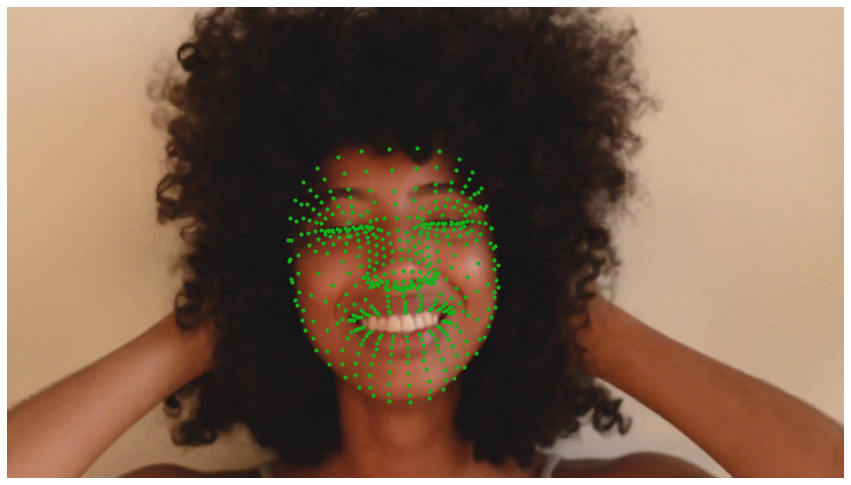

In [18]:
draw(path='test/test_p/00001.jpg')

# Пример обработки двух лиц

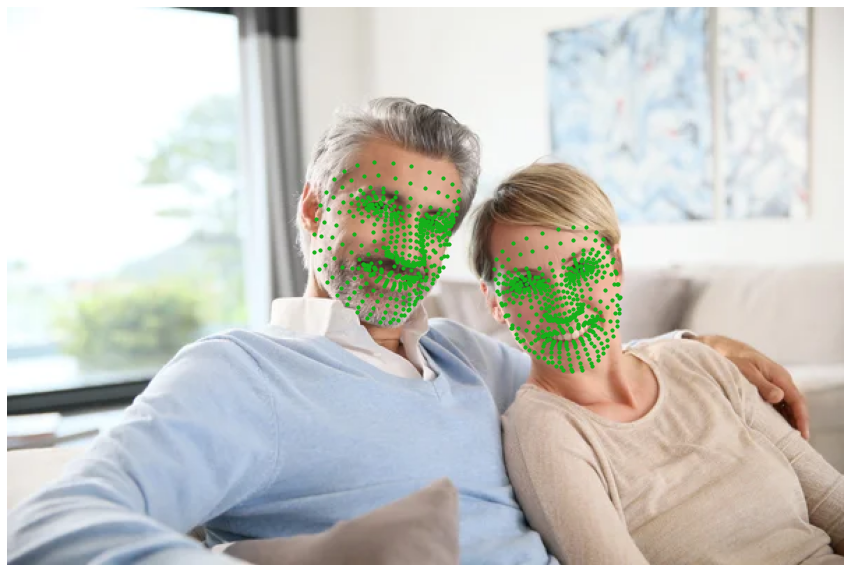

In [23]:
draw(path='test/test_p/11.jpg')

# Пример с группой людей

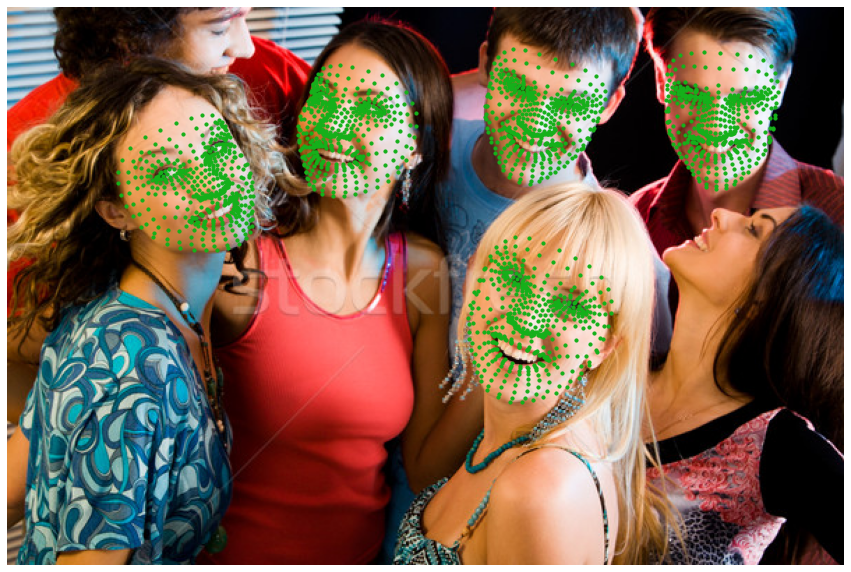

In [25]:
draw(path='test/test_p/12.jpg')

# Создаем Диффузионную карту для визуальной оценки разбиения 

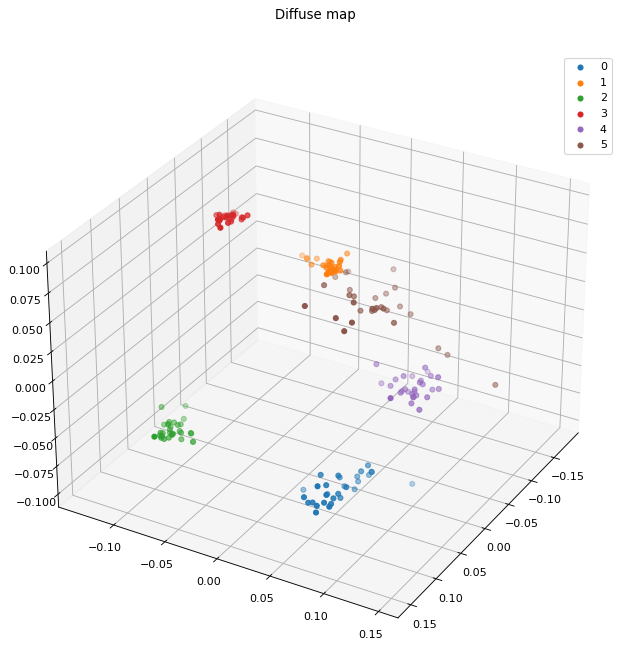

In [22]:
%matplotlib inline
def folders_with_vectors(path, TL_001):
    """
    На вход:
    path - Список с путями до папок, можно ввести сколько угодно
    TL_001 - модель для векторизации
    create_vector(file_list, TL_001) - Функция отвечающая за сбор ландмарков:
    convert_landmark(file) - Получаем 225 точек ландмарков для каждого лица на фотографии
    TL_001(vector) - Применяем обученную модель. Получаем на выходе вектор 128
    """
    #Собирает список файлов из папки
    def create_folder(path):
        file_list = []
        for file in os.listdir(path):
            file_list.append(path + file)

        return file_list
            
    # С помощью медиапайпа получаем ландмарки лица с дальнейшей нормализацией        
    def convert_landmark(path):
        result = []

        mp_face_mesh = mp.solutions.face_mesh

        with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=5, refine_landmarks=True,
            min_detection_confidence=0.5) as face_mesh:

            image = cv2.imread(path)
            output = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            if output:
                for i_face, face in enumerate(output.multi_face_landmarks):
                    x = []
                    y = []
                    z = []

                    mp_indices = sorted([0, 4, 39, 269, 181, 405, 61, 291, 43, 273, 62, 292, 33, 133,
                                         159, 145, 362, 263, 385, 374,148, 176, 149, 150, 136, 172, 58,
                                         215, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109, 10, 338, 297,
                                         332, 284, 251, 389, 356, 264, 447, 366, 401, 435, 288, 397, 365,
                                         379, 378, 400,377, 152, 70, 46, 105, 52, 107, 55, 285, 336, 334,
                                         282, 300, 276, 344, 429, 220, 115])

                    for idx in mp_indices:
                        x.append(output.multi_face_landmarks[i_face].landmark[idx].x)
                        y.append(output.multi_face_landmarks[i_face].landmark[idx].y)
                        z.append(output.multi_face_landmarks[i_face].landmark[idx].z)
                        
                    array = np.array([x, y, z]).T
                    center_0 = np.mean(array,0)
                    centered_lndmrk = array - center_0
                    f_0 = np.linalg.norm(centered_lndmrk, axis = -1)
                    f_1 = centered_lndmrk / np.linalg.norm(f_0)
                    f_2 = f_1.reshape(f_1.shape[0] * f_1.shape[1],)
                    result.append(f_2)

            return np.array(result)
    
    #Получаем вектор для каждого файла из списка с применяем ТриплетЛоссНейросеть для получения вектора признаков
    def create_vector(file_list, TL_001):
        vector_list = []
        for file in file_list:
            vector_225 = convert_landmark(file) #Получаем 225 точек ландмарков для каждого лица на фотографии
            for vector in vector_225: #Если на одной фотографии более одного лица.
                vector_128 = TL_001(vector) # Применяем обученную модель. Получаем на выходе вектор 128
                vector_list.append(vector_128)

        return np.array(vector_list)[:,:]
    
    #Собираем список векторов для каждой папки, которую внесли в переменную path
    def complete(path, TL_001):
        result = []
        for folder in path:
            vectors = create_vector(create_folder(folder), TL_001)
            result.append(vectors)
        
        return result
    
    result = complete(path, TL_001)
    
    return result

def Visualisation_DM(data, eps_, k_, flag):
    """
    На вход следующие параметры:
    data - Список с нампи списками. В каждом нампи списке находятся вектора из отдельной папки
    eps_ - Величена использующаяся для нахождения расстояния между векторами
    k_ - Какое пространство выбирается
    flag - Какую метрику расстояния используем
    """
    
    #Создаем один длинный вектор
    list_shape = [0] #Список, который запоминает сколько векторов в каждой папке. Необходим для создания словаря
    feat = np.zeros((1,data[0].shape[1])) #Изначально создаем 1 вектор с нуля нужной размерности.
    count_cars = 0
    for part in data:
        list_shape.append(part.shape[0] + list_shape[-1])
        feat = np.concatenate((feat, part), axis=0)
        count_cars += 1
    feat = np.delete(feat,0,0)

    
    #Находим собственные вектора и расстояния
    kernel_function = gaussian_kernel_function_dff_00(eps_, flag) #Гауссовское ядро
    similarity_matrix = distance_vec_multi(feat, feat, kernel_function) #Матрица взаимных расстояний N x N зависит от колличества итерраций. 
    L_=similarity_matrix
    eig_values, eig_vectors =diffusion_map_00(L_, k = k_) # Получаем собственные вектора и значения
    eig_vectors = np.real(eig_vectors) # Перевод из мнимых значений в абсолютные

    #Создаем Словарь необходимый для визуализации
    slov = {}
    for i in range(count_cars):
        left_thr = list_shape[i]
        right_thr = list_shape[i+1]
        slov[i] = eig_vectors[left_thr:right_thr,:]
    
    #Визуализируем с помощью функции plot_3d_01
    plot_3d_01(slov)

###########################################################
# path - пути до папок, которые хотим визуализировать
# data - Список с нампи списками. В каждом нампи списке находятся вектора из отдельной папки
# Visualisation_DM - Визуализация Дифф карты

path = ['test/2353/',
        'test/2359/',
        'test/2382/',
        'test/2383/',
        'test/2395/',
        'test/2402/',
       ]
data = folders_with_vectors(path, TL_001)
Visualisation_DM(data, 300.1, 4, 0)